In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [4]:
# visulization style setup
plt.style.use("tableau-colorblind10")
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (12, 7)
plt.rc('grid', ls='-.', c='0A043C', alpha=0.2)
plt.rc('axes', labelsize=12, titlesize=14)

In [9]:
# models needed
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate

In [10]:
data = pd.read_csv('WA_Marketing-Campaign.csv')
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [12]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [13]:
data.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

HeatMap

Visualize the correlation between each variable

From the HeatMap, we can see Sales is negative correlated with MarketID and LocationID.

<AxesSubplot:>

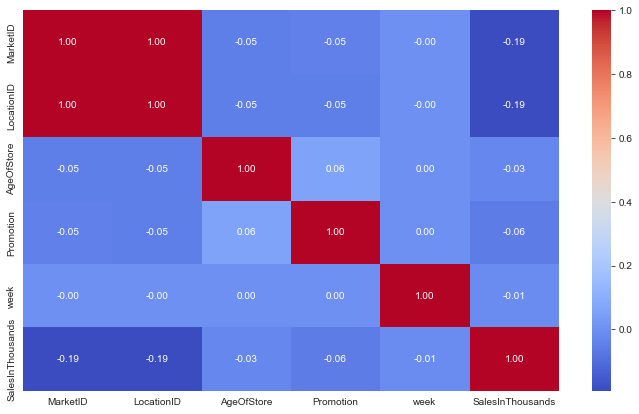

In [14]:
sns.heatmap(data.corr(), annot= True, fmt=".2f",cmap="coolwarm")

Tukey： 多重比较法 多个等方差总体均值比较法。说明各总体均值间差异是否显著。

From the results, we can compare the p-value to get conclusions of effect of promotion.

Group 1 & Group 2: pvalue = 0.001 < 0.05, reject null

Group 1 & Group 3: pvalue = 0.2447 < 0.05, accept null

Group 3 & Group 2: pvalue = 0.001 < 0.05, reject null

So, there is statistically significant difference between promotion 1 & promotion 2 and promotion 2 & promotion 3, but isn't statistically significant difference between promotion 1 & promotion 3.

So, we cannot reject the null hypothesis that the promotions perform equally well.


In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [16]:
tukey = pairwise_tukeyhsd(endog=data['SalesInThousands'],
                          groups=data['Promotion'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2 -10.7696  0.001 -14.774 -6.7652   True
     1      3  -2.7345 0.2447 -6.7389  1.2698  False
     2      3   8.0351  0.001  4.1207 11.9494   True
----------------------------------------------------


In [20]:
category_orders = dict(MarketSize=["Small","Medium","Large"],Promotion=["1","2","3"])

tukey_test = {}

for market in category_orders["MarketSize"]:
    group = data.query(f"MarketSize == '{market}'")
    tukey_test[market] = pairwise_tukeyhsd(
        endog=group["SalesInThousands"],
        groups=group['Promotion'],
        alpha=0.05
    )
for k,v in tukey_test.items():
    print("Market Size: {}, {}\n".format(k,v))

Market Size: Small, Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     1      2  -9.3519 0.001 -13.6829 -5.0208   True
     1      3  -0.6483   0.9  -4.5579  3.2612  False
     2      3   8.7035 0.001    4.536 12.8711   True
----------------------------------------------------

Market Size: Medium,  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.5583  0.001 -11.3108 -5.8057   True
     1      3  -2.2037 0.1356  -4.9113  0.5038  False
     2      3   6.3545  0.001   3.7306  8.9785   True
-----------------------------------------------------

Market Size: Large,  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -14.9139  0.

EDA

In [21]:
# Promotion
data['Promotion'].unique()

array([3, 2, 1])

In [22]:
data['Promotion'].replace({1:"promotion_1",2:"promotion_2",3:"promotion_3"},inplace=True)
data

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,promotion_3,1,33.73
1,1,Medium,1,4,promotion_3,2,35.67
2,1,Medium,1,4,promotion_3,3,29.03
3,1,Medium,1,4,promotion_3,4,39.25
4,1,Medium,2,5,promotion_2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,promotion_1,4,64.34
544,10,Large,920,14,promotion_2,1,50.20
545,10,Large,920,14,promotion_2,2,45.75
546,10,Large,920,14,promotion_2,3,44.29


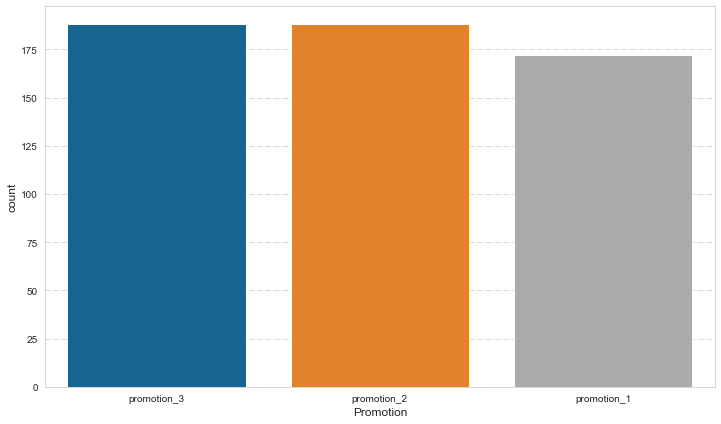

In [23]:
sns.countplot(x='Promotion',data=data)
plt.show()

In [24]:
data_pro = data.groupby(["Promotion"]).agg({"SalesInThousands":["count","mean","median","sum"]})
data_pro

SalesInThousands                             
                       count       mean  median       sum
Promotion                                                
promotion_1              172  58.099012  55.385   9993.03
promotion_2              188  47.329415  45.385   8897.93
promotion_3              188  55.364468  51.165  10408.52

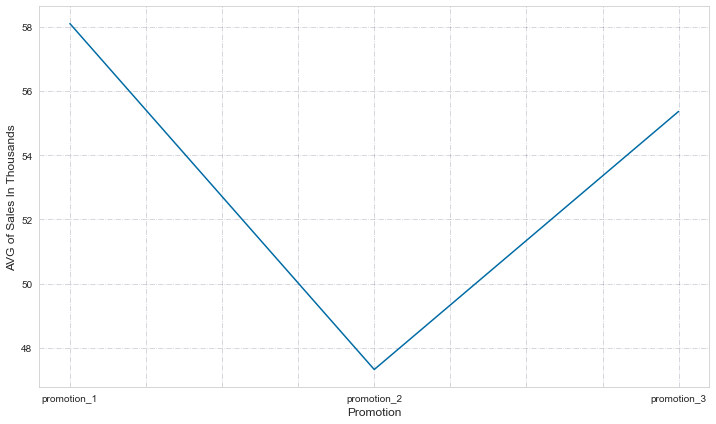

In [25]:
data_pr = data.groupby("Promotion")["SalesInThousands"].mean()

data_pr.plot()
plt.ylabel("AVG of Sales In Thousands")
plt.show()

From the chart and analysis, we can see promotion 1 wins with a higher mean of sales in thousands of 58.

In [26]:
# MarketID
data['MarketID'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

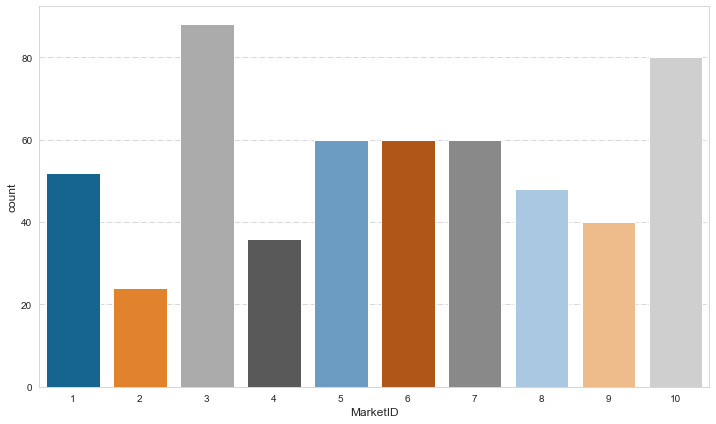

In [27]:
sns.countplot(x='MarketID',data=data)
plt.show()

<AxesSubplot:xlabel='Promotion'>

<Figure size 720x720 with 0 Axes>

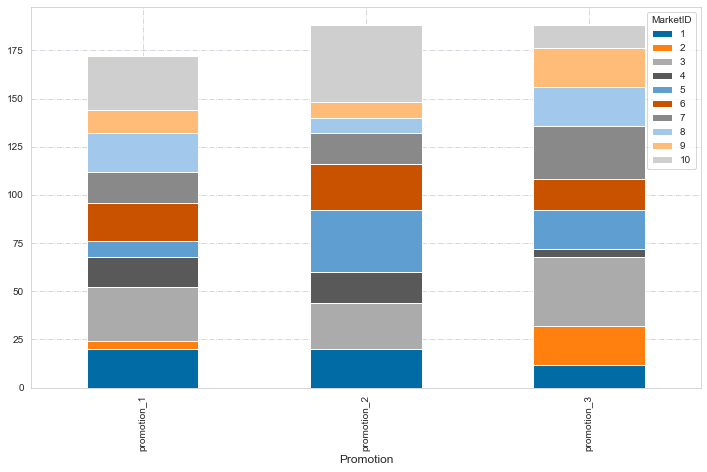

In [28]:
plt.figure(figsize=(10,10))
data.groupby(['Promotion','MarketID']).size().unstack().plot(kind='bar',stacked=True)


In [29]:
occur_mar_pro = data.groupby(['MarketID','Promotion']).size()
display(occur_mar_pro)

MarketID  Promotion  
1         promotion_1    20
          promotion_2    20
          promotion_3    12
2         promotion_1     4
          promotion_3    20
3         promotion_1    28
          promotion_2    24
          promotion_3    36
4         promotion_1    16
          promotion_2    16
          promotion_3     4
5         promotion_1     8
          promotion_2    32
          promotion_3    20
6         promotion_1    20
          promotion_2    24
          promotion_3    16
7         promotion_1    16
          promotion_2    16
          promotion_3    28
8         promotion_1    20
          promotion_2     8
          promotion_3    20
9         promotion_1    12
          promotion_2     8
          promotion_3    20
10        promotion_1    28
          promotion_2    40
          promotion_3    12
dtype: int64

In [30]:
data_mi = data.groupby(["MarketID"]).agg({"SalesInThousands":["count","mean","median","sum"]})
data_mi

SalesInThousands                            
                    count       mean  median      sum
MarketID                                             
1                      52  35.101731  35.675  1825.29
2                      24  61.761250  61.875  1482.27
3                      88  84.971705  84.090  7477.51
4                      36  54.508056  54.035  1962.29
5                      60  48.838000  48.740  2930.28
6                      60  36.397500  36.750  2183.85
7                      60  44.475333  43.385  2668.52
8                      48  48.952917  49.650  2349.74
9                      40  52.940750  52.525  2117.63
10                     80  53.776250  52.930  4302.10

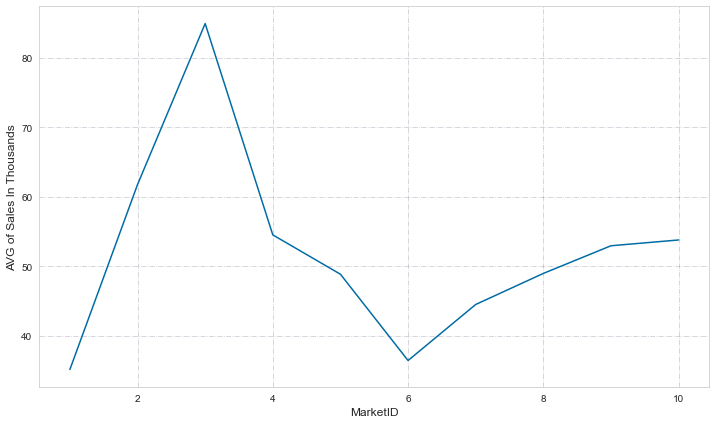

In [31]:
data_mk = data.groupby("MarketID")["SalesInThousands"].mean()

data_mk.plot()
plt.ylabel("AVG of Sales In Thousands")
plt.show()

<AxesSubplot:xlabel='Promotion', ylabel='SalesInThousands'>

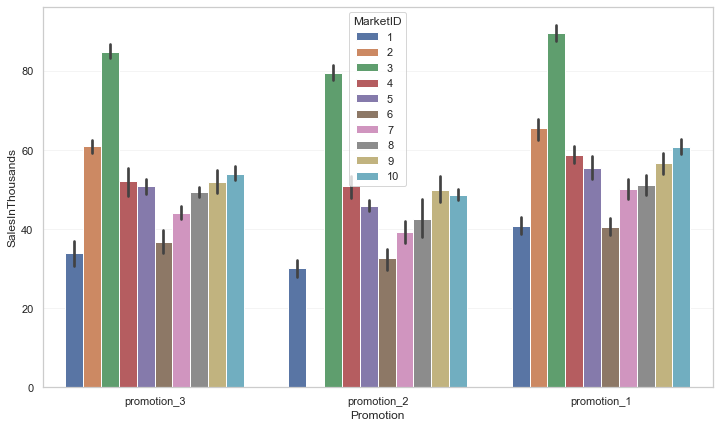

In [32]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.barplot(x=data['Promotion'],y=data['SalesInThousands'],hue=data['MarketID'],data=tips)

From the chart, we can see MarketID 3 wins with a highest average sales amount and performs the best with promotion 1.

In [33]:
# MarketSize
data["MarketSize"].unique()

array(['Medium', 'Small', 'Large'], dtype=object)

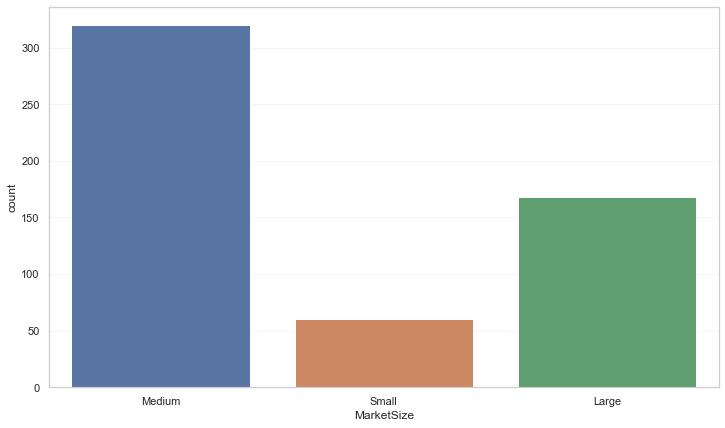

In [34]:
sns.countplot(x="MarketSize",data=data)
plt.show()

In [35]:
data_ma = data.groupby(['MarketSize']).agg({"SalesInThousands":["count","mean","median","sum"]})
data_ma

SalesInThousands                             
                      count       mean  median       sum
MarketSize                                              
Large                   168  70.116726  75.020  11779.61
Medium                  320  43.985344  44.590  14075.31
Small                    60  57.409333  57.555   3444.56

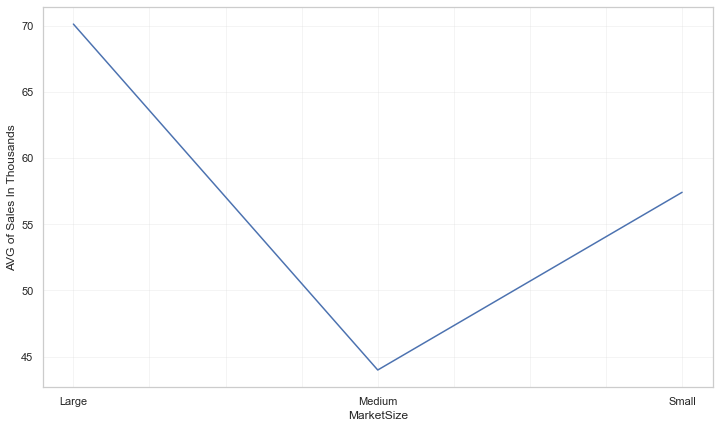

In [36]:
data_ms = data.groupby("MarketSize")["SalesInThousands"].mean()
data_ms.plot()
plt.ylabel("AVG of Sales In Thousands")
plt.show()

<AxesSubplot:xlabel='Promotion', ylabel='SalesInThousands'>

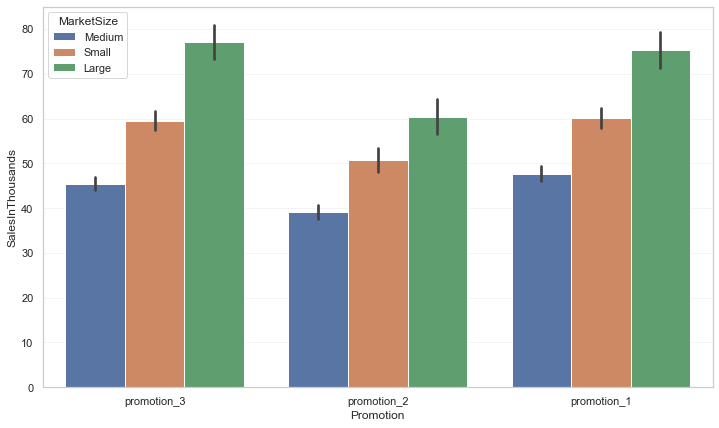

In [37]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.barplot(x=data["Promotion"],y=data["SalesInThousands"],hue=data["MarketSize"],data=tips)


The chart shows large market wins with the best result being in promotion1.

In [39]:
# Age of Store
data_age = data.groupby(["AgeOfStore"]).agg({"SalesInThousands":["count","mean","median","sum"]})
data_age

SalesInThousands                            
                      count       mean  median      sum
AgeOfStore                                             
1                        80  58.415625  55.170  4673.25
2                        20  59.179500  56.795  1183.59
3                        32  60.227500  54.195  1927.28
4                        44  53.437727  47.220  2351.26
5                        44  48.818636  45.845  2148.02
6                        36  51.366667  49.230  1849.20
7                        40  52.128750  49.880  2085.15
8                        40  50.475750  44.380  2019.03
9                        28  48.996071  47.695  1371.89
10                       24  39.313750  43.445   943.53
11                       16  57.159375  51.955   914.55
12                       24  47.482917  43.135  1139.59
13                       20  59.642500  54.495  1192.85
14                       12  49.063333  49.805   588.76
15                        8  42.673750  41.690   341.39
17                        4  49.937500  50.700   199.75
18                        8  50.710000  51.950   405.68
19                       20  63.638000  63.100  1272.76
20                        4  60.202500  60.385   240.81
22                       12  59.688333  61.930   716.26
23                        8  65.097500  64.810   520.78
24                       12  51.140833  51.010   613.69
25                        4  45.425000  45.340   181.70
27                        4  52.392500  53.435   209.57
28                        4  52.285000  51.600   209.14

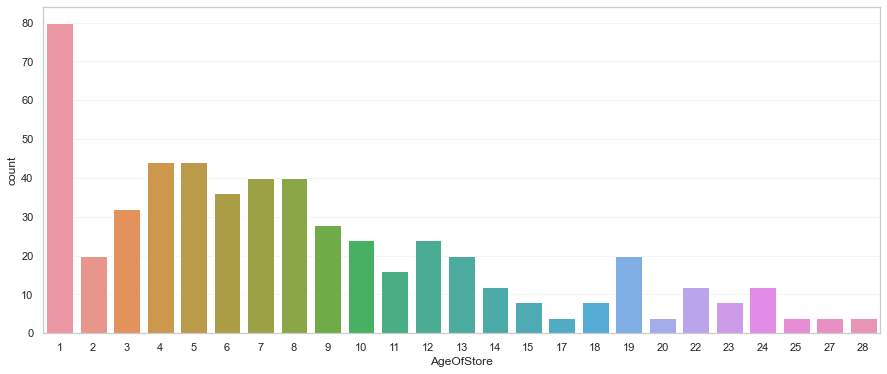

In [40]:
fig_dims = (15,6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='AgeOfStore',data=data)
plt.show()

In [42]:
data.groupby(["AgeOfStore","Promotion"]).agg({"SalesInThousands":["count","mean","median"]})


SalesInThousands                   
                                  count       mean  median
AgeOfStore Promotion                                      
1          promotion_1               24  65.781250  61.650
           promotion_2               36  49.643333  47.915
           promotion_3               20  65.367000  56.295
2          promotion_1                8  76.112500  75.650
           promotion_2                8  43.173750  44.710
           promotion_3                4  57.325000  57.360
3          promotion_1               16  66.271250  62.720
           promotion_2               12  44.655000  45.190
           promotion_3                4  82.770000  83.530
4          promotion_1               16  45.713750  46.820
           promotion_2               12  53.334167  47.300
           promotion_3               16  61.239375  60.985
5          promotion_1                8  68.562500  68.800
           promotion_2               12  29.450833  28.640
           promotion_3               24  51.921250  48.740
6          promotion_1               20  55.872500  49.865
           promotion_2                4  49.325000  48.670
           promotion_3               12  44.537500  45.700
7          promotion_1                4  42.190000  41.405
           promotion_2               24  55.217500  52.465
           promotion_3               12  49.264167  50.610
8          promotion_1               12  61.541667  56.850
           promotion_2                8  39.793750  38.905
           promotion_3               20  48.109000  44.380
9          promotion_1                8  53.440000  56.065
           promotion_2               12  46.573333  45.060
           promotion_3                8  48.186250  48.790
10         promotion_2               16  39.001875  40.815
           promotion_3                8  39.937500  43.445
11         promotion_1                4  53.760000  54.905
           promotion_3               12  58.292500  49.750
12         promotion_1               12  40.279167  37.630
           promotion_2                4  31.005000  33.655
           promotion_3                8  66.527500  64.510
13         promotion_1               12  55.405833  54.495
           promotion_2                8  65.997500  65.685
14         promotion_2                8  47.111250  47.040
           promotion_3                4  52.967500  52.665
15         promotion_1                4  43.242500  42.540
           promotion_2                4  42.105000  39.270
17         promotion_3                4  49.937500  50.700
18         promotion_1                8  50.710000  51.950
19         promotion_1                4  89.262500  88.755
           promotion_2                8  39.421250  39.305
           promotion_3                8  75.042500  74.565
20         promotion_3                4  60.202500  60.385
22         promotion_1                4  65.600000  66.525
           promotion_3                8  56.732500  54.375
23         promotion_2                4  77.200000  77.620
           promotion_3                4  52.995000  53.140
24         promotion_1                4  60.490000  62.350
           promotion_3                8  46.466250  45.385
25         promotion_2                4  45.425000  45.340
27         promotion_1                4  52.392500  53.435
28         promotion_2                4  52.285000  51.600

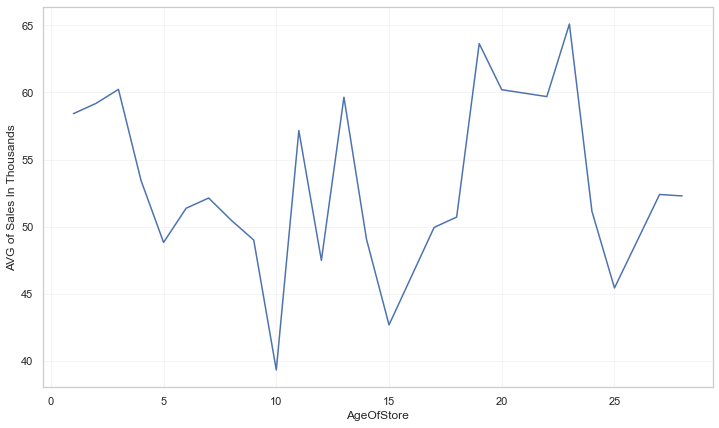

In [43]:
data_as = data.groupby("AgeOfStore")['SalesInThousands'].mean()

data_as.plot()
plt.ylabel("AVG of Sales In Thousands")
plt.show()

<AxesSubplot:xlabel='Promotion'>

<Figure size 720x864 with 0 Axes>

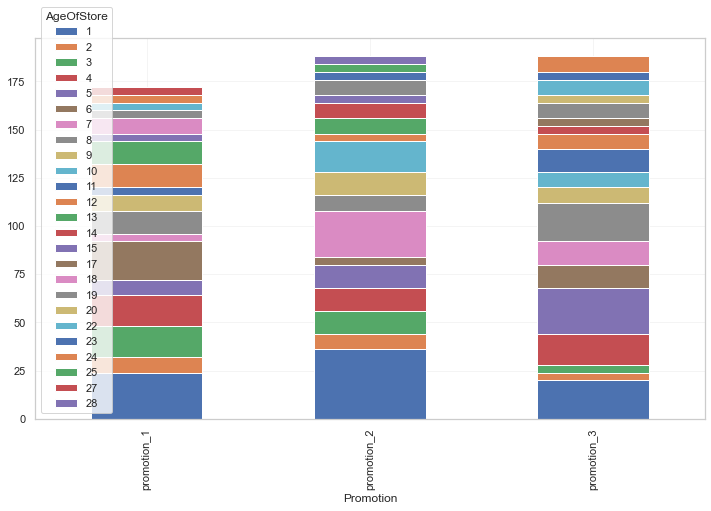

In [44]:
plt.figure(figsize=(10,12))
data.groupby(['Promotion','AgeOfStore']).size().unstack().plot(kind='bar',stacked=True)

The analysis shows that store aged 23 wins on generating highest sales amount, with the best result being promotion1.

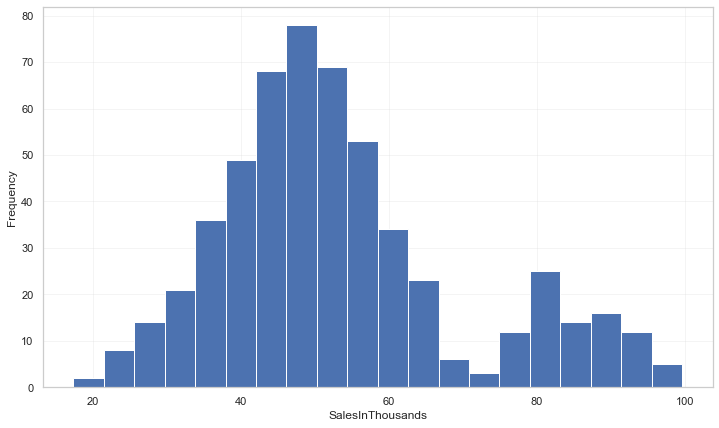

In [47]:
# Sales in Thousands
plt.hist(data['SalesInThousands'], bins=20)
plt.xlabel("SalesInThousands")
plt.ylabel("Frequency")
plt.show()

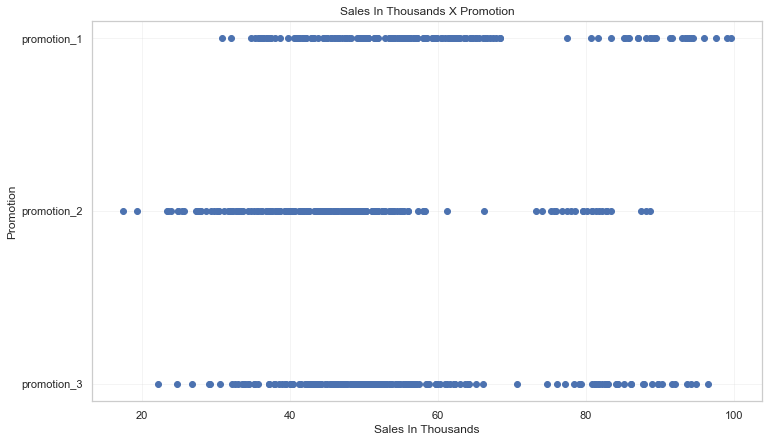

In [48]:
plt.scatter(data['SalesInThousands'],data['Promotion'])
plt.title("Sales In Thousands X Promotion")
plt.xlabel("Sales In Thousands")
plt.ylabel("Promotion")
plt.show()

In [50]:
# week
data['week'].unique()

array([1, 2, 3, 4])

In [51]:
data_week = data.groupby(['week']).agg({"SalesInThousands":["count","mean","median","sum"]})
data_week

SalesInThousands                           
                count       mean median      sum
week                                            
1                 137  53.790584  50.20  7369.31
2                 137  53.386569  51.09  7313.96
3                 137  53.474599  50.11  7326.02
4                 137  53.213066  49.71  7290.19

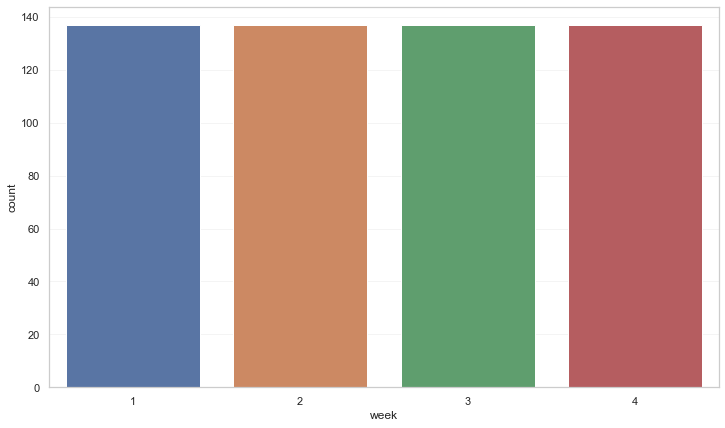

In [52]:
sns.countplot(x='week',data=data)
plt.show()

In [53]:
occur_wee_pro = data.groupby(['week','Promotion']).size()
display(occur_wee_pro)

week  Promotion  
1     promotion_1    43
      promotion_2    47
      promotion_3    47
2     promotion_1    43
      promotion_2    47
      promotion_3    47
3     promotion_1    43
      promotion_2    47
      promotion_3    47
4     promotion_1    43
      promotion_2    47
      promotion_3    47
dtype: int64

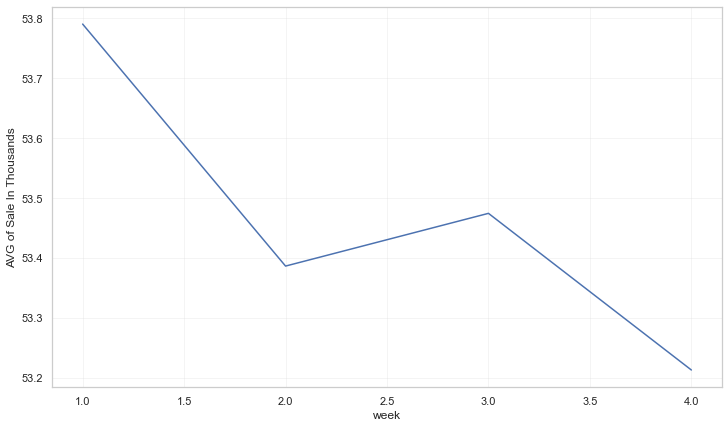

In [54]:
data_week=data.groupby("week")["SalesInThousands"].mean()

data_week.plot()
plt.ylabel("AVG of Sale In Thousands")
plt.show()

<AxesSubplot:xlabel='Promotion', ylabel='SalesInThousands'>

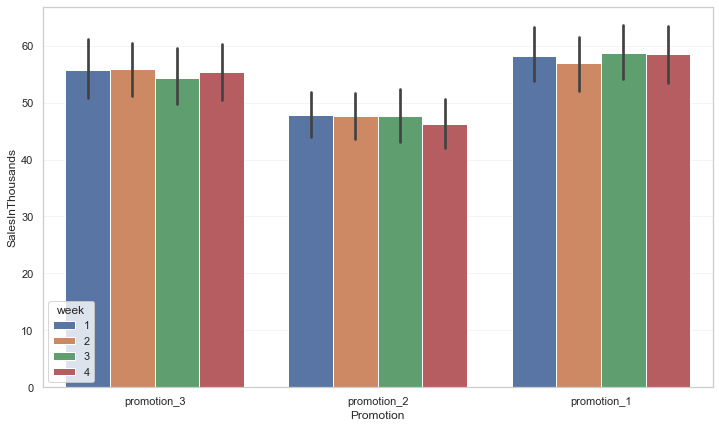

In [55]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.barplot(x=data['Promotion'],y=data['SalesInThousands'],hue=data['week'],data=tips)


Analysis shows that 4 weeks performed similarly, but with promotion1 performs best.

Final Conclusion for EDA: which promotion performed best(generate highest return on sales)?

Promotion:

MarketID:

MarketSize:

AgeOfStore:

Week:


Modeling

In [56]:
data['Promotion'].replace({"promotion_1":1,"promotion_2":2,"promotion_3":3},inplace=True)
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [57]:
# encodeing Marketsize

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['MarketSize'])
data['MarketSize'] = encoder.transform(data['MarketSize'])
print(data["MarketSize"])

0      1
1      1
2      1
3      1
4      1
      ..
543    0
544    0
545    0
546    0
547    0
Name: MarketSize, Length: 548, dtype: int64


In [58]:
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,1,1,4,3,1,33.73
1,1,1,1,4,3,2,35.67
2,1,1,1,4,3,3,29.03
3,1,1,1,4,3,4,39.25
4,1,1,2,5,2,1,27.81


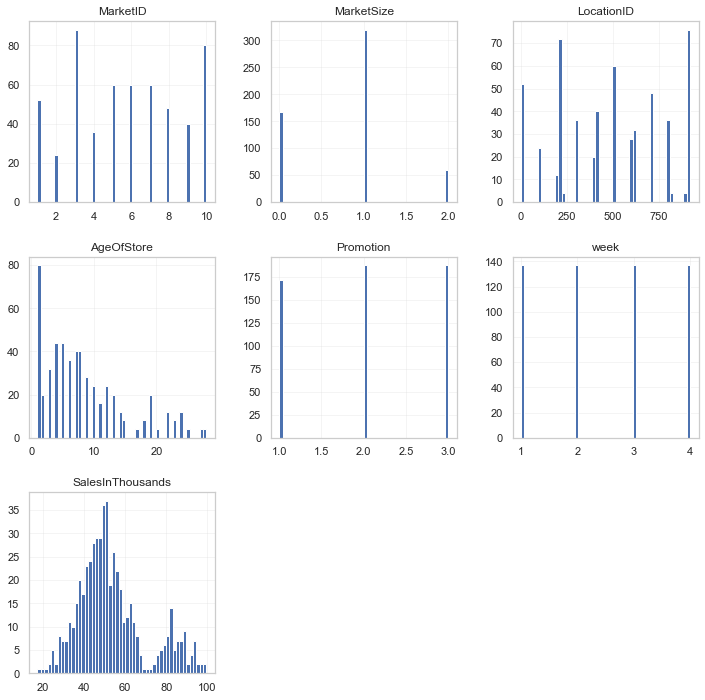

In [59]:
# histgram

data.hist(bins=50,figsize=(12,12))
plt.show()

In [60]:
data.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

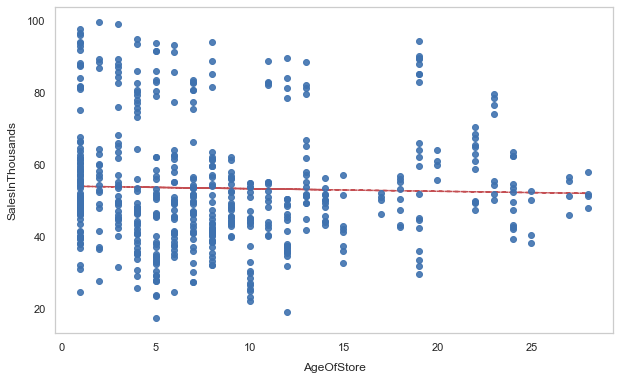

In [61]:
# scatter

fig,ax = plt.subplots(figsize=(10,6))
ax.grid()
ax.scatter(data["AgeOfStore"],data["SalesInThousands"], c="#3f72af",zorder=3,alpha=0.9)
ax.set_xlabel("AgeOfStore",labelpad=10)
ax.set_ylabel("SalesInThousands",labelpad=10)
z = np.polyfit(data["AgeOfStore"],data["SalesInThousands"],1)
p = np.poly1d(z)
plt.plot(data["AgeOfStore"],p(data["AgeOfStore"]),"r--")
plt.show()

In [63]:
train_data, test_data = train_test_split(data, train_size=0.8)

In [64]:
X_train = train_data.drop("SalesInThousands",axis=1)
y_train = train_data["SalesInThousands"]
X_test = test_data.drop("SalesInThousands",axis=1).copy()
y_test = test_data["SalesInThousands"]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((438, 6), (438,), (110, 6), (110,))

In [65]:
# Linear Regression

lr=LinearRegression()
lr.fit(X_train,y_train)
Y_pred = lr.predict(X_test)
acc_lr= round(lr.score(X_train, y_train)*100,2)
acc_lr

31.99

In [66]:
# XGBregression

xgb = XGBRegressor()
xgb.fit(X_train,y_train)
Y_pred = xgb.predict(X_test)
acc_xgb = round(xgb.score(X_train,y_train)*100,2)
acc_xgb

99.85

In [67]:
# random forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train,y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train,y_train)*100,2)
acc_random_forest

98.34

In [68]:
# decision tree

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train,y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train,y_train)*100,2)
acc_decision_tree

100.0

In [70]:
# catboost

catboost = CatBoostRegressor(verbose=False)
catboost.fit(X_train,y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train,y_train)*100,2)
acc_catboost

97.8

In [71]:
# print accurate rate for all models

models = pd.DataFrame({
    'Model': ['Linear Regression','RandomForest','XGB','DecisionTree','CatBoost'],
    'Score':[acc_lr,acc_random_forest,acc_xgb,acc_decision_tree,acc_catboost]})
models.sort_values(by='Score',ascending=False)


,Model,Score
3,DecisionTree,100.00
2,XGB,99.85
1,RandomForest,98.34
4,CatBoost,97.80
0,Linear Regression,31.99


In [72]:
# kfold cross validation select the best model

models = {'DTR':DecisionTreeRegressor(),
          'RFR':RandomForestRegressor(),
          'XGBR':XGBRegressor(),
          'LIRE':LinearRegression(),
          'CAT':CatBoostRegressor(verbose=False)}

scores = {}
for name, model in models.items():
    kfold = RepeatedKFold(n_splits=2,n_repeats=3)
    score = cross_val_score(model,X_train,y_train,scoring='r2',cv=kfold,n_jobs=-1)
    scores[name] = np.mean(score)
    print("%s score:: %.2f (%.3f)" %(name,np.mean(score),np.std(score)))

DTR score:: 0.80 (0.031)
RFR score:: 0.87 (0.010)
XGBR score:: 0.83 (0.024)
LIRE score:: 0.29 (0.029)
CAT score:: 0.88 (0.005)


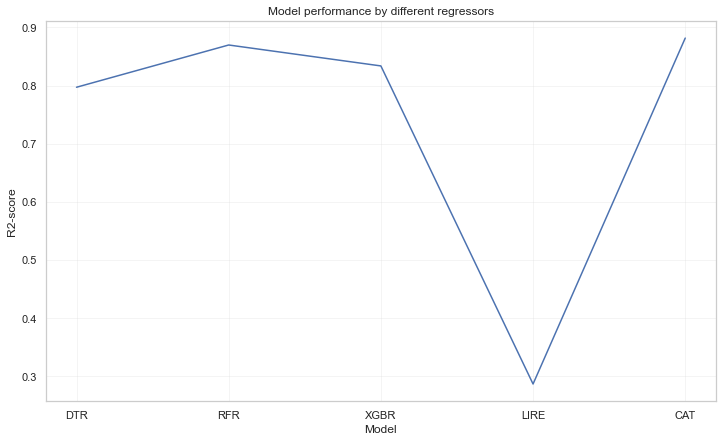

In [73]:
# visualize score

sns.lineplot(x=scores.keys(),y=scores.values())
plt.title("Model performance by different regressors")
plt.xlabel("Model")
plt.ylabel("R2-score")
plt.show()

From the chart, random forest has the highest r2, performs best.

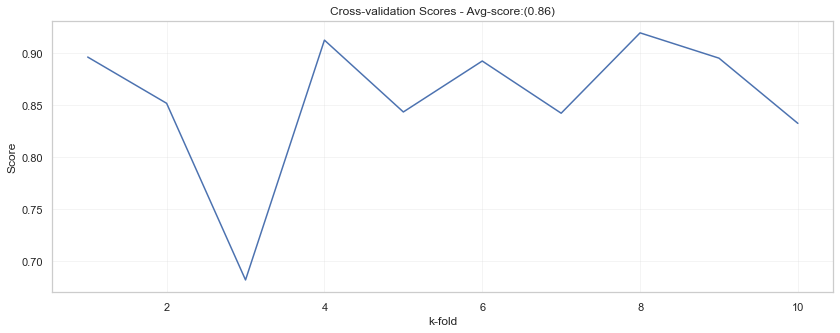

In [74]:
# cross validation scores for random forest regressor

scores = cross_val_score(random_forest,X_train,y_train,cv=10,scoring='r2',n_jobs=-1)
kfolds = list(range(1,11))

# plots
plt.figure(figsize=(14,5))
sns.lineplot(x=kfolds,y=scores)
plt.xlabel("k-fold")
plt.ylabel("Score")
plt.title("Cross-validation Scores - Avg-score:(%.2f)" %(np.mean(scores)))
plt.show()

In [75]:
# residual

predicted = cross_val_predict(random_forest,X_train,y_train,cv=10,n_jobs=-1)
residual = y_train-predicted

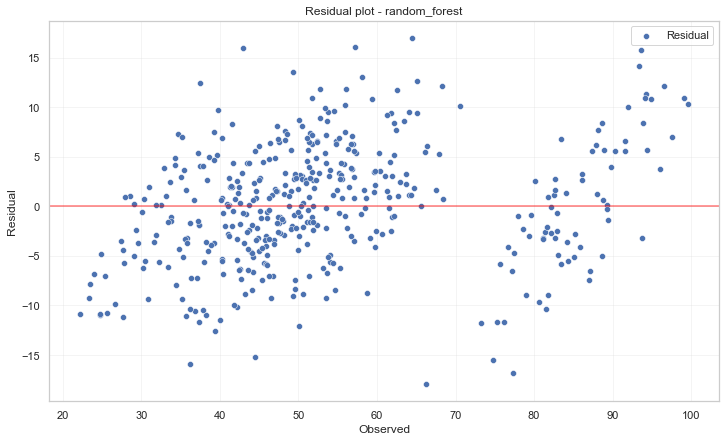

In [77]:
# visualize residual

sns.scatterplot(x=y_train,y=residual,label="Residual")
plt.axhline(lw=2,color='red',alpha=0.4)
plt.xlabel("Observed")
plt.ylabel("Residual")
plt.title("Residual plot - random_forest")
plt.show()

In [79]:
seed = 1234

np.random.seed(seed)
model = RandomForestRegressor(verbose=False)
results = cross_validate(model,X_train,y_train,cv=10,return_train_score=False)
mean = results['test_score'].mean()
std = results['test_score'].std()
print("Accuracy interval with cross validation of 10 folds = [%.2f,%.2f]" % ((mean-2*std)*100,(mean+2*std)*100))

Accuracy interval with cross validation of 10 folds = [71.92,98.85]


In [80]:
acc_random_forest

98.34

In [81]:
random_forest=RandomForestRegressor(verbose=False)
random_forest.fit(X_train,y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_test,y_test)*100,2)
acc_random_forest

81.35